<a href="https://colab.research.google.com/github/CedrickArmel/sep25_alt1_mle_ds_covid1/blob/dev_Rodrigue/notebooks/1_0_eda_radiography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for exploratory analysis of COVID-19 Radiography database from Kaggle : https://www.kaggle.com/tawsifurrahman/covid19-radiography-datab
ase


# **COVID CLASSIFICATION PROJECT**

In [159]:
! pip install opencv-python joblib scikit-image openpyxl
# ! pip install tqdm

In [4]:
import os
import zipfile
from collections import defaultdict
from glob import glob
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import drive
from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm

In [5]:
#Fonction de vérification de la taille réélle des images
def check_size(images):
  records = []
  for rep, imgs in images.items():
      for i, img in enumerate(imgs):
          if img is not None:
              records.append({"rep": rep, "index": i, "shape": img.shape})

  df_dims = pd.DataFrame(records)
  print(df_dims)

In [6]:
def single_image_haralick(
    img: np.array, features: list, distances: list[int], angles: np.array
) -> dict[str, np.array]:
    """Computes a set of Haralick features for a single image."""
    glcm = graycomatrix(
        img, distances=distances, angles=angles, symmetric=True, normed=True
    )  # calcul de la GLCM
    result = {}
    for ft in features:
        props = graycoprops(glcm, prop=ft)  # Calcul des statistiques de Haralick
        result[ft] = props
    return result

In [7]:
def compute_haralick_parallel(
    images: list[np.ndarray],
    features: list,
    distances: list[int],
    angles: np.array,
    n_jobs: int = -1,
    verbose=1,
) -> list[dict]:
    """Computes a set of Haralick features for a set of images in parallel using joblib."""
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(single_image_haralick)(img, features, distances, angles)
        for img in images
    )
    return results

In [8]:
def display_haralick(d: str, directions: dict[str, int], haralick_features: dict[str, dict], ncols: int = 2):
  nrows = np.ceil(len(haralick_features) / ncols).astype(int)
  fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
  axes = axes.flatten()
  for i, ft in enumerate(haralick_features):
    for rep in haralick_features[ft].keys():
      axes[i].plot(np.mean(haralick_features[ft][rep][:, directions[d]::4], axis=1), label=f"{rep.upper()}")
    axes[i].set_title(ft.capitalize())
    # axes[i].legend(title="Health Status")

  for j in range(i + 1, len(axes)):
          axes[j].axis('off')

  handles, labels = axes[0].get_legend_handles_labels()
  fig.legend(
        handles,
        labels,
        title="Health Status",
        loc="center right",
        bbox_to_anchor=(0.98, 0.3)
    )
  fig.suptitle(f"Caractéristique de Haralick selon la direction {d.capitalize() if "diagonal" not in d else "Diagonal"} - {directions[d] * 45}°", fontsize=16)
  fig.supxlabel("Distance entre $x$ et $y$", fontsize=14)
  fig.supylabel("Valeur des caractéristiques", fontsize=14, x=0)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.tight_layout()
  plt.show()

In [9]:
# Fonction pour représenter toutes les features Haralick ensemble
def boxplot_all_haralick(haralick_features: dict):
    features = list(haralick_features.keys())
    categories = list(
        next(iter(haralick_features.values())).keys()
    )  # prend les keys d'une feature
    n_features = len(features)

    # Préparer les données au format "long" pour seaborn
    data_list = []
    for ft in features:
        for rep in categories:
            values = np.mean(haralick_features[ft][rep], axis=0)
            for v in values:
                data_list.append(
                    {"Feature": ft.capitalize(), "Category": rep.upper(), "Value": v}
                )

    df_plot = pd.DataFrame(data_list)

    # Création du boxplot
    plt.figure(figsize=(22, 8))
    sns.boxplot(x="Feature", y="Value", hue="Category", data=df_plot)
    plt.title("Distribution des features Haralick par catégorie")
    plt.ylabel("Valeur moyenne de la feature")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.legend(title="Catégorie")
    plt.tight_layout()
    plt.show()

In [10]:
def heatmap_haralick_all(haralick_features: dict):
    """
    Affiche une heatmap de corrélation des features Haralick
    pour chaque catégorie (COVID, Normal, etc.)
    """
    for rep in next(iter(haralick_features.values())).keys():

        # Construction du DataFrame des features
        df = pd.DataFrame(
            {
                ft: np.mean(haralick_features[ft][rep], axis=0)
                for ft in haralick_features
            }
        )

        # Matrice de corrélation
        corr = df.corr()

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", square=True
        )
        plt.title(f"Corrélation entre features Haralick – {rep.upper()}")
        plt.tight_layout()
        plt.show()

In [11]:
def radar_all_haralick(haralick_features: dict, reps: list):
    import matplotlib.pyplot as plt
    from math import pi
    import numpy as np

    features = list(haralick_features.keys())
    N = len(features)

    # Angles du radar
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    for rep in reps:
        values = [np.mean(haralick_features[ft][rep]) for ft in features]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=rep.upper())
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=11)
    ax.set_title("Radar chart – Signatures des textures Haralick", fontsize=11)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

In [13]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CHEMINS ET CHARGEMENT DES DONNEES

## IMPORTANT

- Les sorties de ce notebook doivent être écrites directement dans le dossier approprié de `PROJECT_ROOT`.
- Ne jamais rien écrire dans `PROJECT_ROOT/data/01_raw` et `SESSION_DIR`
-  `SESSION_DIR` ne sert que pour une extraction et un accès plus rapidement aux données brutes. Ses données ne sont pas persitées d'une session à l'autre comme toutes les données dans `/content/` sauf celles de `content/drive/`.


In [14]:
RunningInCOLAB = "google.colab" in str(get_ipython())

In [15]:
# @title VARIABLES DE SESSION
# @markdown
PROJECT_ROOT = (
    "/content/drive/MyDrive/sep25_alt1_mle_ds_covid1"  # @param {type: "string"}
)
DATA_ROOT = "COVID-19_Radiography_Dataset"  # @param {type: "string"}
# @markdown ---

In [24]:
if RunningInCOLAB:
    PROJECT_ROOT = Path(PROJECT_ROOT)
    ZIP_PATH = PROJECT_ROOT / "data/01_raw/COVID-19_Radiography_Dataset.zip"
    SESSION_DIR = Path("/content/sep25_alt1_mle_ds_covid1")
    RAW_DATA = SESSION_DIR / DATA_ROOT
else:
    RAW_DATA = Path(DATA_ROOT)
REPS = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [25]:
#!ls "/content/drive/MyDrive"

base_path = (
    "/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"
)
classes = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [26]:
# Vérification du contenu du repo sep25_alt1_mle_ds_covid1
!ls "/content/drive/MyDrive/sep25_alt1_mle_ds_covid1"

data  Rapport1.gdoc


In [28]:
if RunningInCOLAB:
    # Extraction de l'archive des données brutes dans ZIP_DEST
    if os.path.exists(RAW_DATA) and os.listdir(RAW_DATA):
        print(f"Le dossier '{RAW_DATA}' existe déjà et n'est pas vide.")
    else:
        os.makedirs(SESSION_DIR, exist_ok=True)
        with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
            zip_ref.extractall(SESSION_DIR)

    ! chmod -R a=rX $SESSION_DIR

Le dossier '/content/sep25_alt1_mle_ds_covid1/COVID-19_Radiography_Dataset' existe déjà et n'est pas vide.


##**CHARGEMENT & ANALYSE EXPLORATOIRE DES DONNEES**

In [29]:
metadata = pd.concat(
    [pd.read_excel(file) for file in glob(os.path.join(RAW_DATA, "*.metadata.xlsx"))]
)
metadata.columns = ["file_name", "format", "size", "url"]

In [30]:
images = defaultdict()

In [31]:
for rep in REPS:
    images[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "images/*.png"))
    ]

In [32]:
check_size(images)

          rep  index       shape
0       covid      0  (299, 299)
1       covid      1  (299, 299)
2       covid      2  (299, 299)
3       covid      3  (299, 299)
4       covid      4  (299, 299)
...       ...    ...         ...
21160  normal  10187  (299, 299)
21161  normal  10188  (299, 299)
21162  normal  10189  (299, 299)
21163  normal  10190  (299, 299)
21164  normal  10191  (299, 299)

[21165 rows x 3 columns]


In [33]:
metadata.head()

,file_name,format,size,url
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


**Remarque**:Toutes les images sont de tailles 299 x 299 alors que les masques sont de dimension 256 x 256.
Il est donc necessaire de faire un redimensionnement afin que les masques et les images aient les mêmes dimensions. Nous avons choisi de redimensionner les images en 256 x 256.

In [34]:
images_resized = {}
for rep, imgs in images.items():
    images_resized[rep] = []
    for img in imgs:
        if isinstance(img, np.ndarray):
            resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
            images_resized[rep].append(resized)


In [35]:
check_size(images_resized)

          rep  index       shape
0       covid      0  (256, 256)
1       covid      1  (256, 256)
2       covid      2  (256, 256)
3       covid      3  (256, 256)
4       covid      4  (256, 256)
...       ...    ...         ...
21160  normal  10187  (256, 256)
21161  normal  10188  (256, 256)
21162  normal  10189  (256, 256)
21163  normal  10190  (256, 256)
21164  normal  10191  (256, 256)

[21165 rows x 3 columns]


## **ANALYSE TEXTURALES DES IMAGES**

La texture d’une image désigne la structure spatiale de l’intensité de luminosité des pixels, qui se répète périodiquement sur l’ensemble de l’image ou sur certaines de ses parties, et qui caractérise la nature de l’image.

Analyser la texture d'une image consiste à essayer de découvrir les motifs qui se repètent et de les extraire sous forme d'une valeur numérique. Répéter cet exercie évolutif à l'échelle de tout notre jeu de données peut nous permettre d'identifier les motifs caractéristiques de chaque catégorie d'images et des biais potentiels.

Plusieurs méthode existent pour analyser la texture d'une image, mais pour cette analyse nous faisons le choix arbitraire d'appliquer une approche qui se base sur la matrice de co-occurence des niveaux de gris ou *Gray-Level Cooccurence Matrix (GLCM)*\[[1](https://colab.research.google.com/drive/1Lntxtu_EDeoG5Rv8eux6W-FDcxn8oZFv#scrollTo=CriYcJt1oZTx&line=5&uniqifier=1)\].

Pour une image avec 256 niveaux de gris, la matrice de co-occurence GLCM est de taille 256 x 256.

Chaque cellule de la matrice de co-occurence GLCM de coordonées $(x, y)$ représente le nombre de fois le niveau de gris $x$ a été observé sous une relation $d$ avec le niveau $y$ dans cette image.

La GLCM est un opérateur statistique et probabiliste qui permet d'extraire des statistiques d'une image qui peuvent représenter sa texture. Ces statistiques dites de Haralick sont: moyenne, variance, entropie, contraste, dissimilarité, homogeneité, ASM, énergie et corrélation.


## **CALCUL DES CARACTERISTIQUES DE HARALICK**

### **EXPLICATION**:
Dans la cellule ci-dessus, les arguments `distances` (distance en pixels entre $x$ et $y$) et `angles` (direction en radians de $y$ par rapport à $x$), de la fonction `graycomatrix` de calcul de la GLCM, constituent la relation $d$ entre $x$ et $y$.

A partir de la GLCM, `graycoprops` calcule successivement les caractéristiques de Haralick suivantes:

*   **Moyenne (mean)** : $\sum_{i=0}^{levels-1} i*P_{i}$
*   **Ecart-type (std)** : $\sqrt{variance} = \sqrt{\sum_{i=0}^{levels-1} P_{i}*(i-mean)^2}$
*   **Entropie (entropy)** : $\sum_{i,j=0}^{levels-1} -P_{i,j}*log(P_{i,j})$
*   **Contraste (contrast)**: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$
*   **Homogénéité (homogeneity)** : $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$
*   **Energie (energy)** : $\sqrt{ASM} = \sqrt{\sum_{i,j=0}^{levels-1}P_{i,j}}$
*   **Corrélation (correlation)** : $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)
(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

Mais il est également de calculer ces caractéristiques que nous laissons délibérément de côté car elles apportent des informations similaires à celles calculés:
*   **Dissimilarité (dissimilarity)** : $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$ similaire au contraste.
*   **ASM**, voir énergie
*   **Variance**, voir écart-type.


In [36]:
DMAX = 29
HARALICK_FEATURES = ["mean", "std", "entropy", "contrast", "homogeneity", "energy", "correlation"]
DIRECTIONS = {"horizontal": 0, "diagonal1": 1, "vertical": 2, "diagonal2": 3}
ANGLES = (np.pi / 4) * np.arange(0, 4)  # angles in rad from 0 to pi

In [37]:
haralick_features = {}
haralick_features_norm = {}

In [38]:
# Charger et normaliser
for ft in HARALICK_FEATURES:
    haralick_features[ft] = {}
    haralick_features_norm[ft] = {}
    for rep in images_resized.keys():
        # Charger le fichier
        data = np.load(PROJECT_ROOT / f"data/00_dumps/haralick_features_{ft}_{rep}.npy")
        haralick_features[ft][rep] = data

        # Normalisation min-max
        data_flat = data.flatten()
        data_norm = (data_flat - np.min(data_flat)) / (np.max(data_flat) - np.min(data_flat) + 1e-8)
        haralick_features_norm[ft][rep] = data_norm.reshape(data.shape)

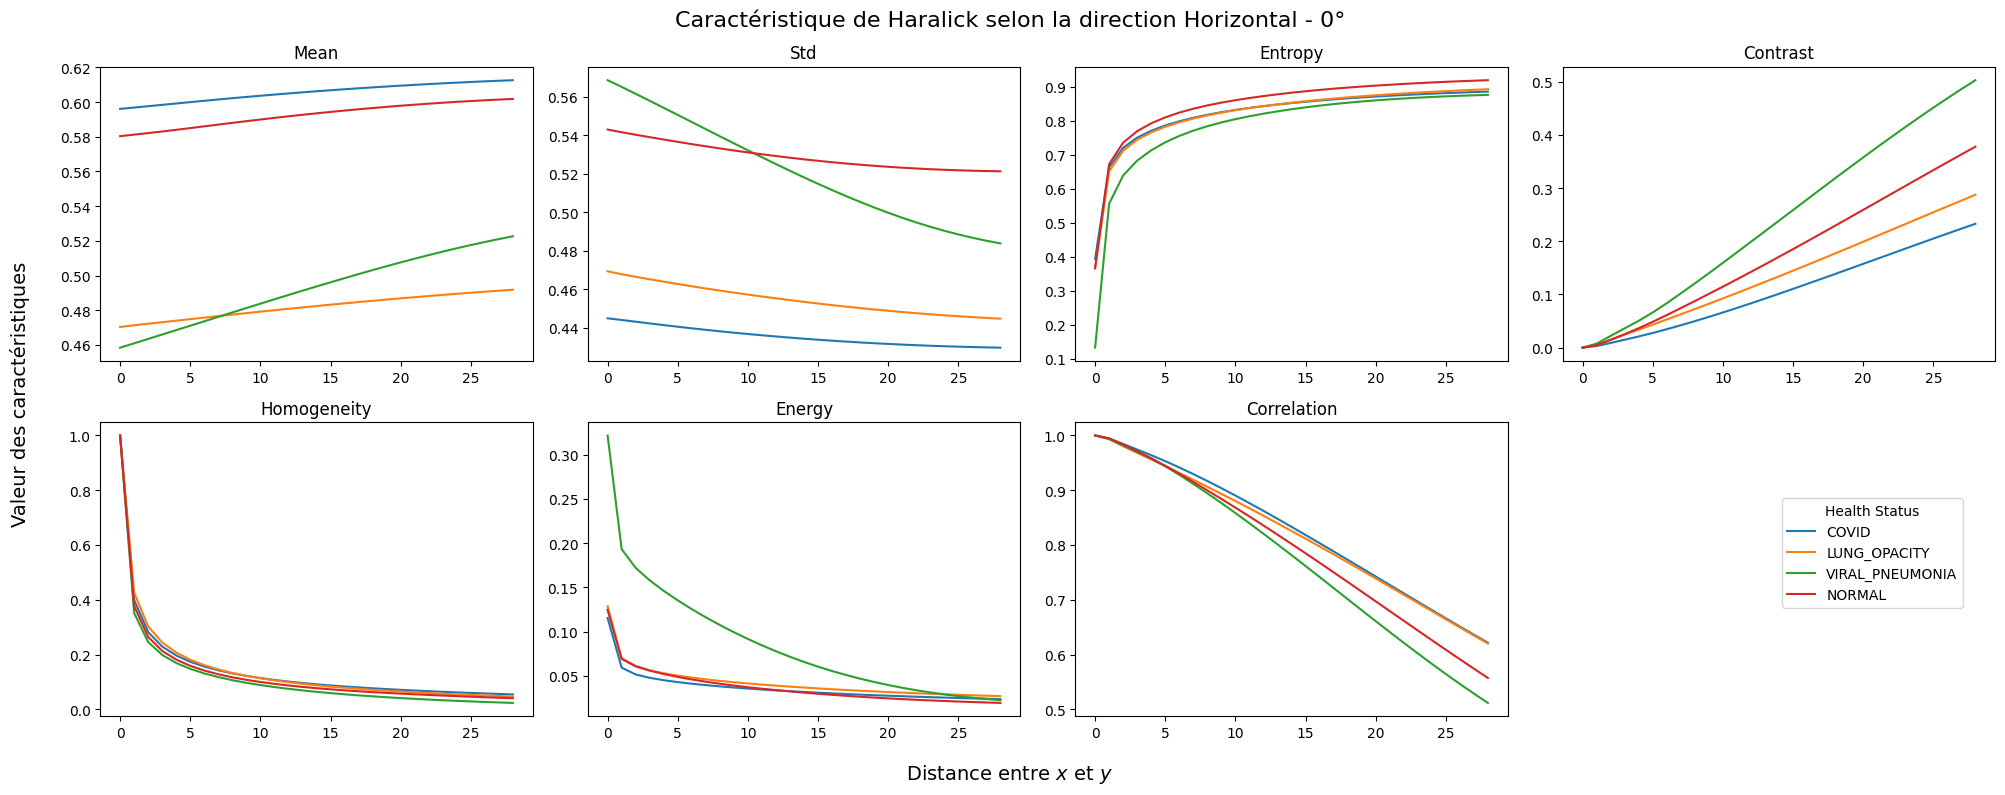

In [39]:
# Maintenant on peut appeler la fonction
display_haralick(
    d="horizontal", directions=DIRECTIONS, haralick_features=haralick_features_norm, ncols=4
)

# **VISUALISATION ET INTERPRETATION**

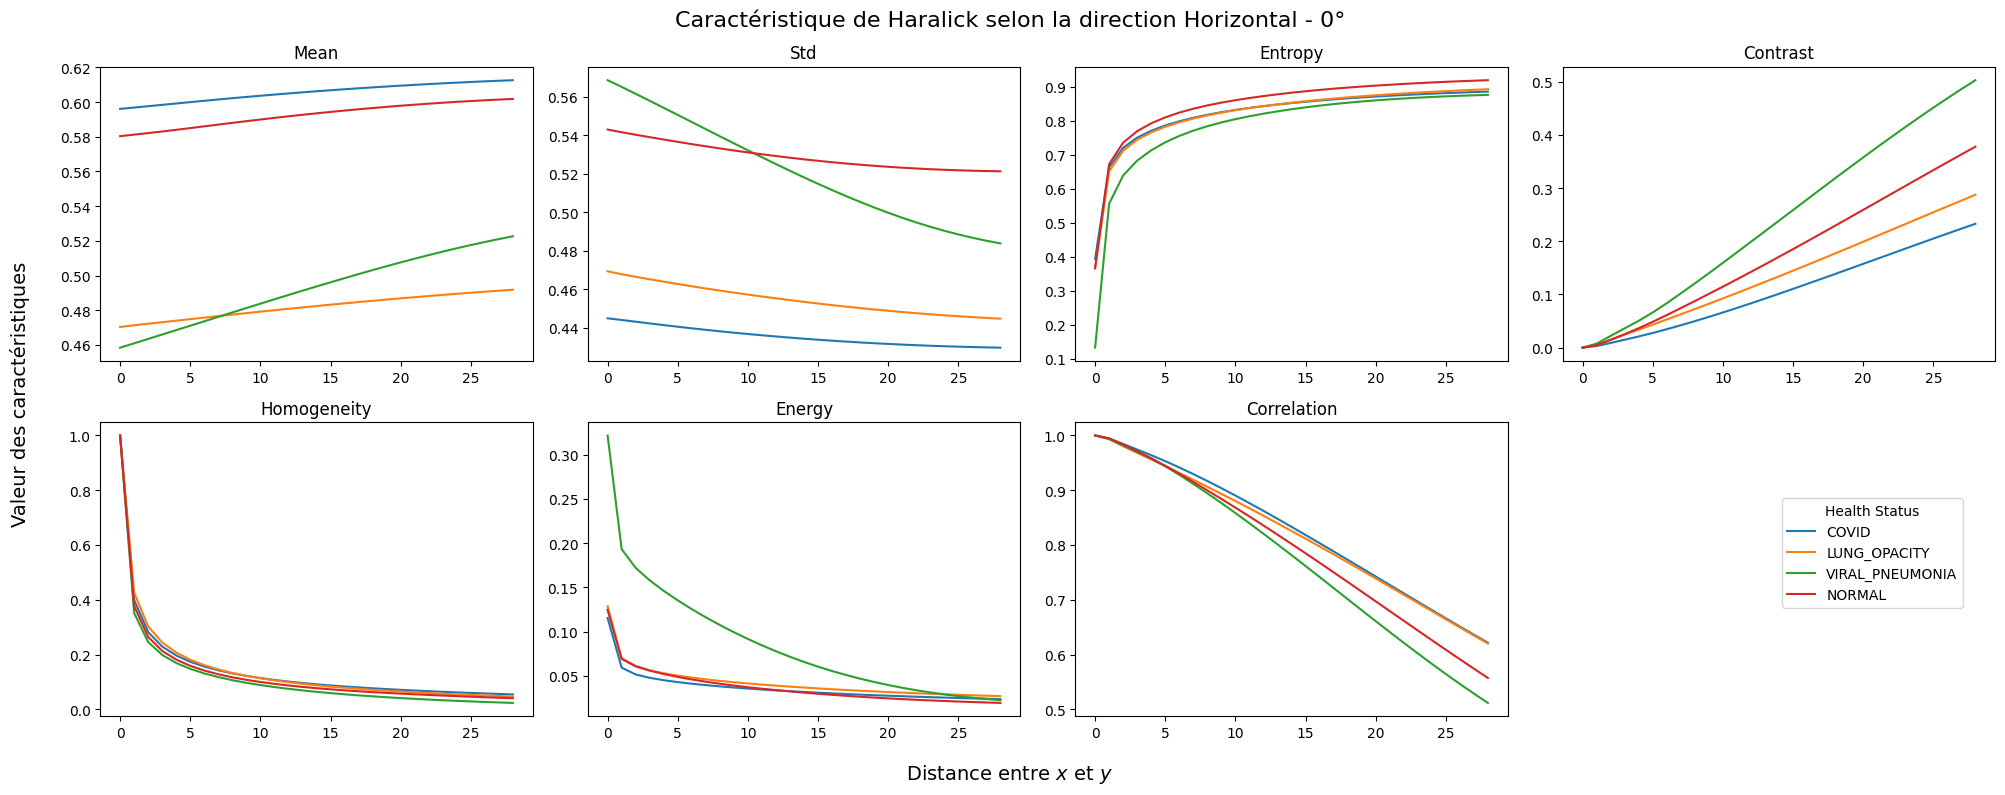

In [41]:
# Appel fonction
display_haralick(
    d="horizontal", directions=DIRECTIONS, haralick_features=haralick_features_norm, ncols=4
)

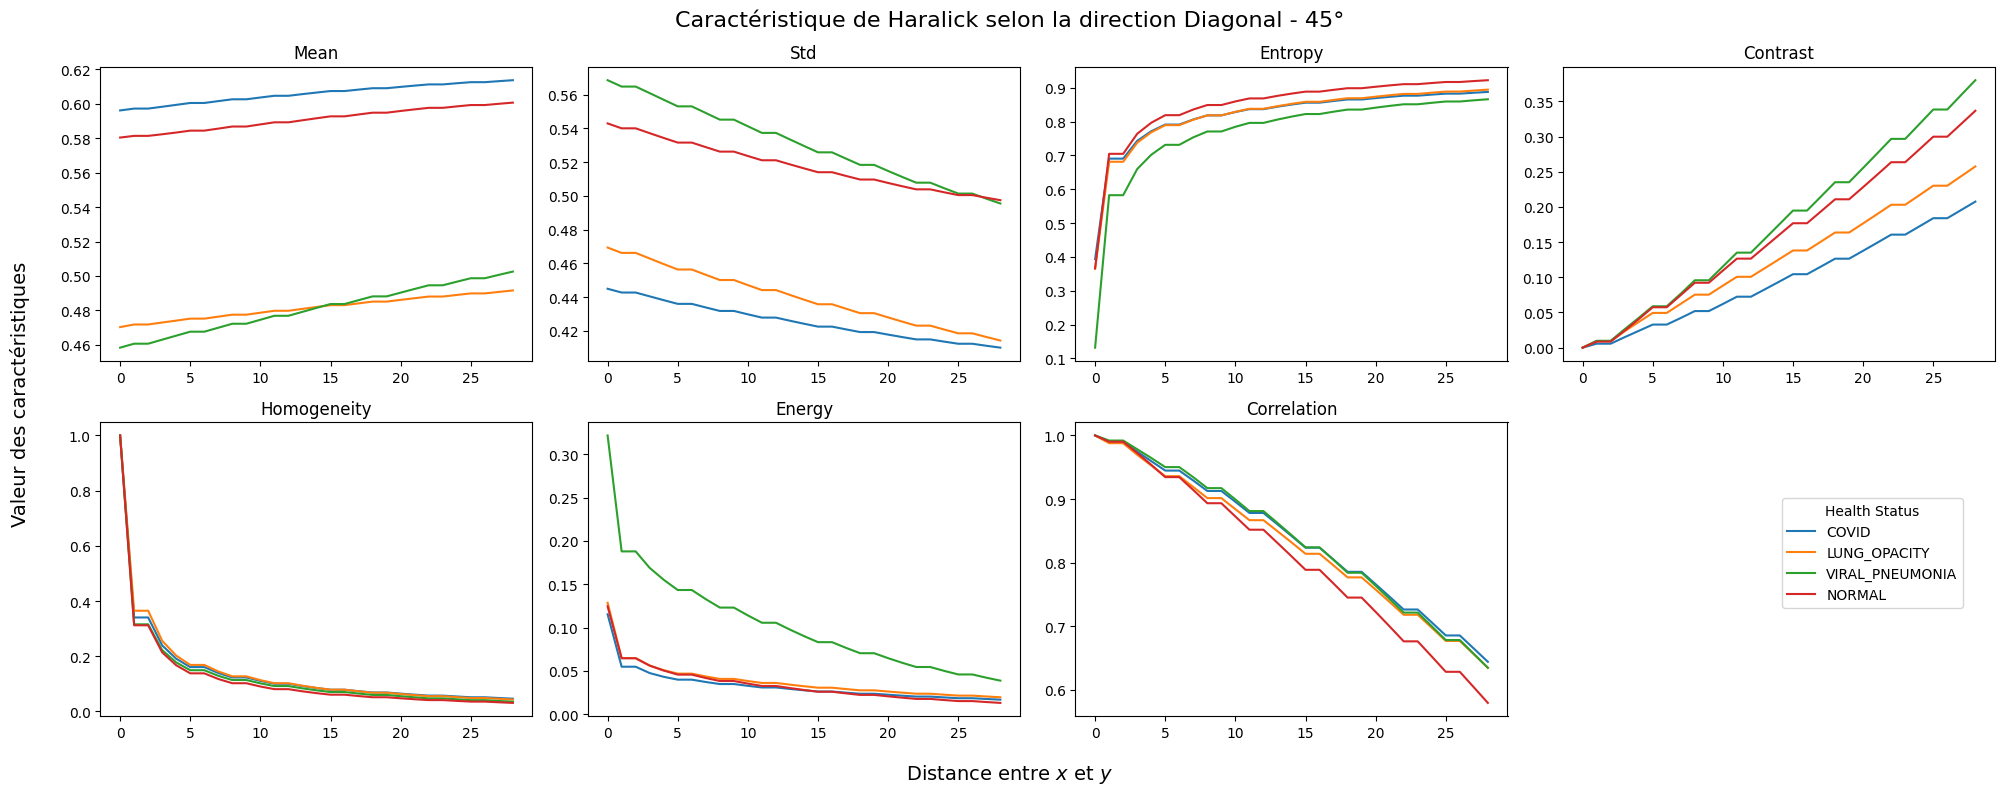

In [42]:
# Appel fonction
display_haralick(
    d="diagonal1", directions=DIRECTIONS, haralick_features=haralick_features_norm, ncols=4
)

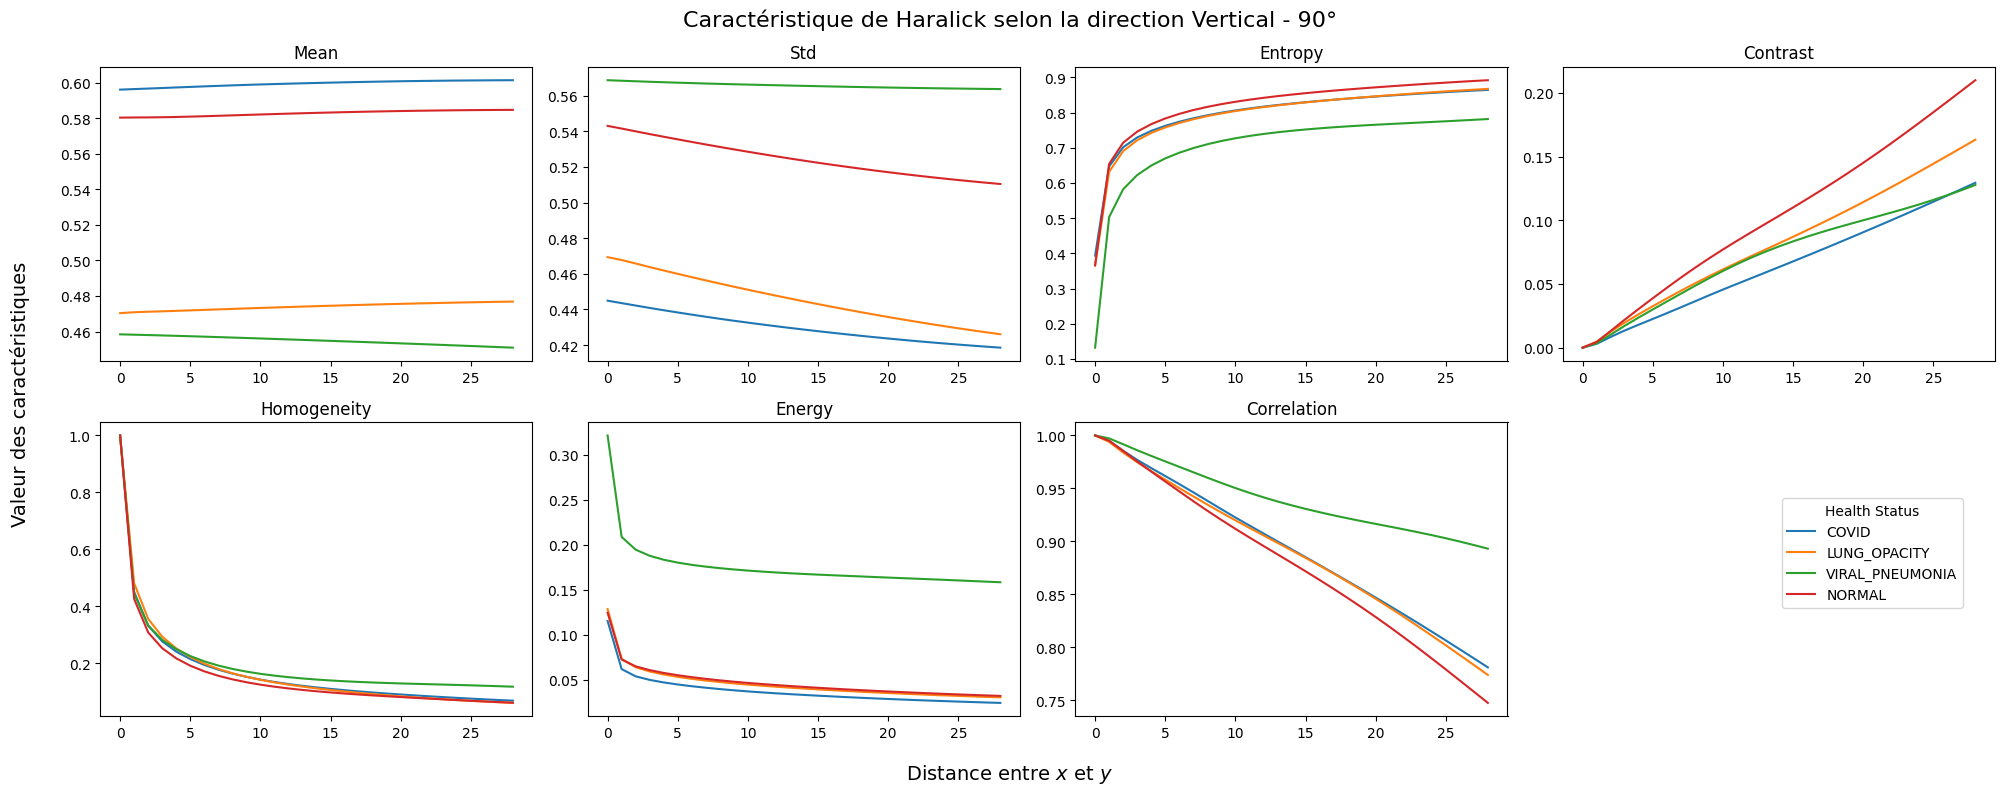

In [43]:
# Appel fonction
display_haralick(
    d="vertical", directions=DIRECTIONS, haralick_features=haralick_features_norm, ncols=4
)

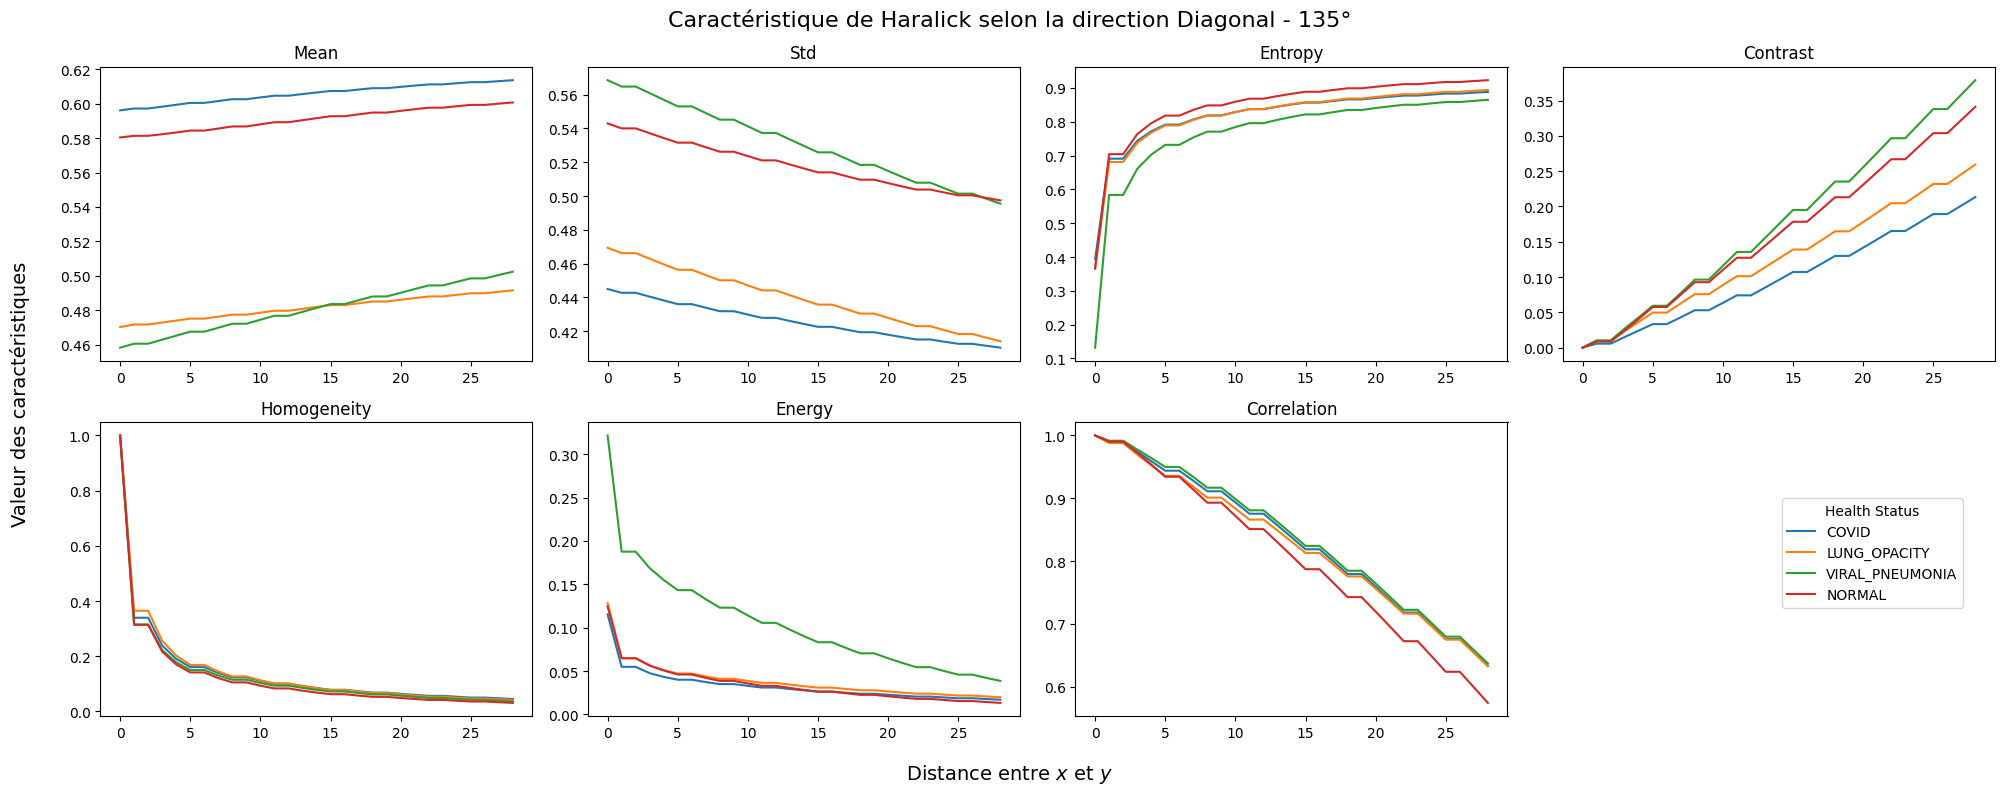

In [44]:
# Appel fonction
display_haralick(
    d="diagonal2", directions=DIRECTIONS, haralick_features=haralick_features_norm, ncols=4
)

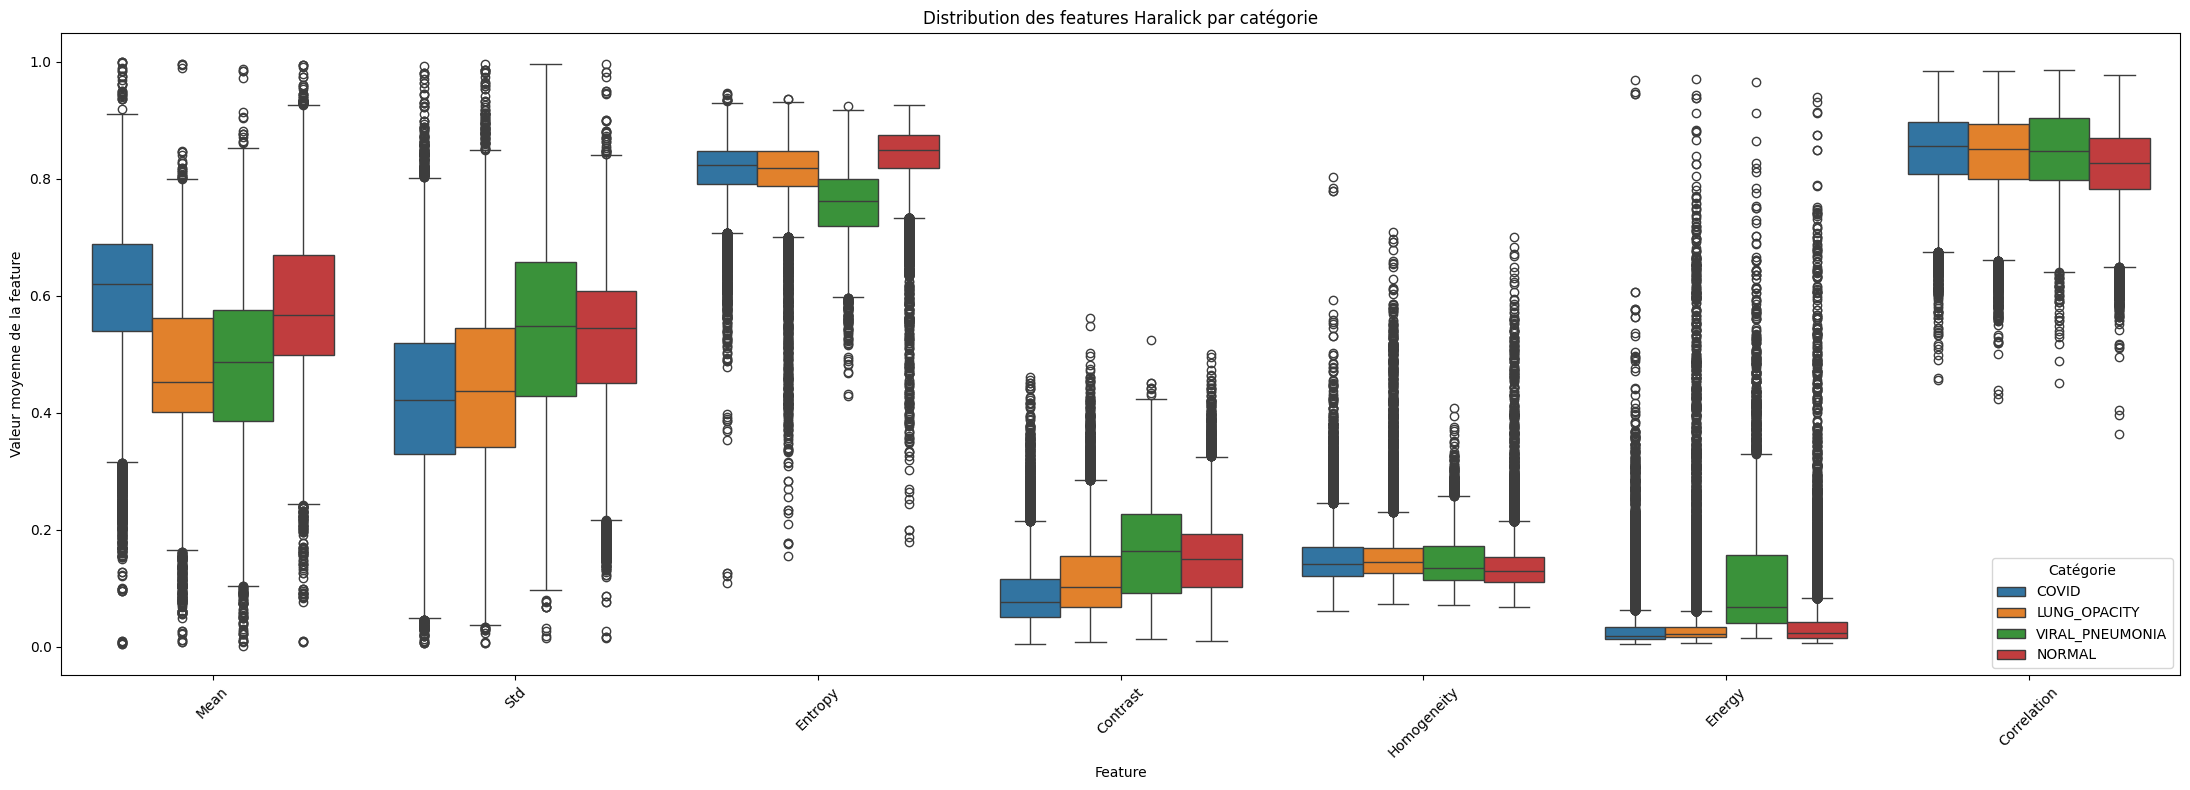

In [45]:
# Appel de la fonction boxplot_all_haralick
boxplot_all_haralick(haralick_features_norm)

**INTERPRETATION DU GRAPHIQUE (BOITE A MOUSTACHE)**

**Distribution générale**

Chaque feature Haralick est représentée sur l’axe des x.
Les valeurs moyennes par image sont représentées sur l’axe des y.
Chaque couleur correspond à une catégorie de santé pulmonaire :
*   COVID (bleu)
*   Lung Opacity (orange)
*   Viral Pneumonia (vert)
*   Normal (rouge)

Features spécifiques :

Suite à la normalisation des features Mean, Std, Entropy, Homogeneity, Energy, Correlation, en tendance générale, on remarque que Les classes Normal et Viral sont celles présentant une grandes variations. Au niveau du feature Homogeneity, la distribution est pratiquement la même pour toutes les classes. On peut donc dire que cette feature n'est pas discriminatoire en ce qui concerne la classification des pathologies.

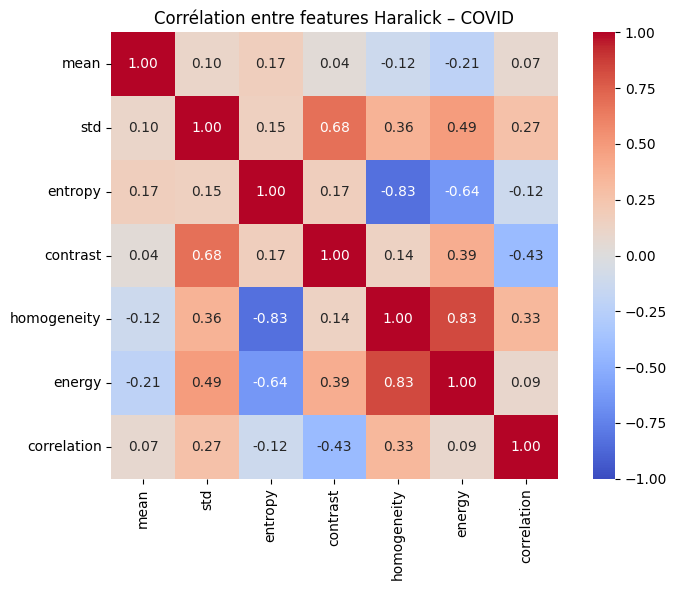

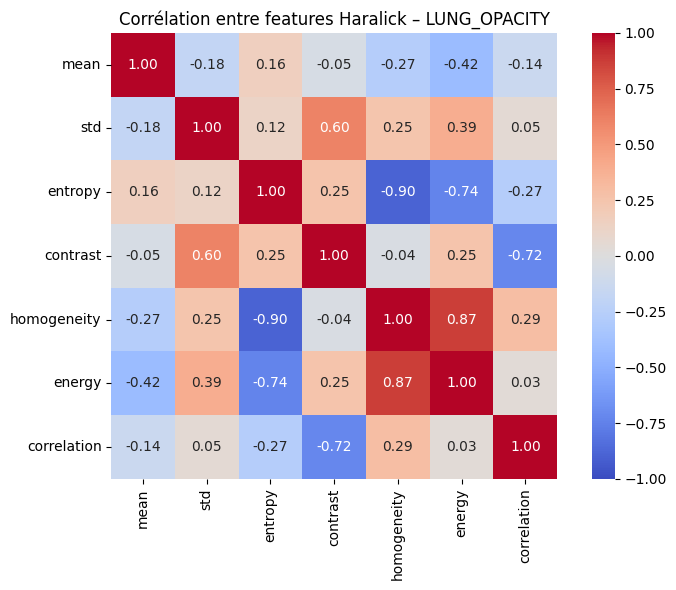

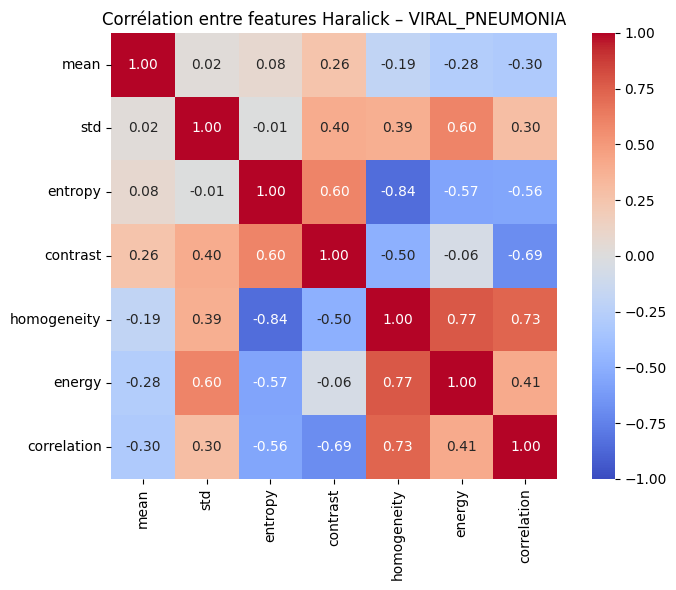

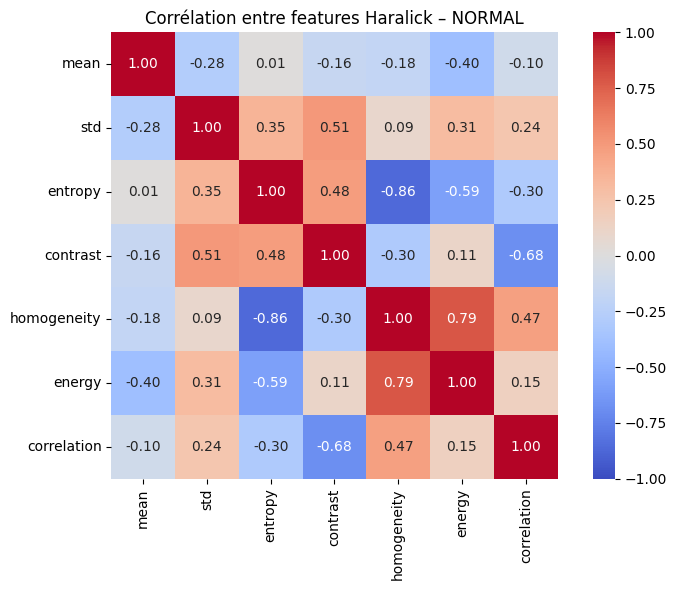

In [46]:
# Appel de la fonction
heatmap_haralick_all(haralick_features_norm)

 **INTERPRETATION DES MATRICES DE CORRELATION DE PEARSON**

D’après la matrice de correlation de la pathologie COVID, on note une forte correlation entre les features energy et homogeneity (+0.83%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.83%).
La matrice de correlation de la pathologie LUNG_OPACITY, on note une forte correlation entre les features energy et homogeneity (+0.87%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.90%).
La matrice de correlation de la pathologie VIRAL_PNEUMONIA, on note une forte correlation entre les features energy et homogeneity (+0.77%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.84%).
La matrice de correlation de la pathologie NORMAL, on note une forte correlation entre les features energy et homogeneity (+0.79%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.86%).

De tout ce qui précède, il ressort qu'il existe une forte opposition entre entropy et homogeneity dans les images, traduisant une texture pulmonaire désorganisée. Certaines caractéristiques comme energy et homogeneity apparaissent redondantes donc on doit en selectionner une partie pour ne pas avoir un défaut de performance au niveau de notre future modèle.

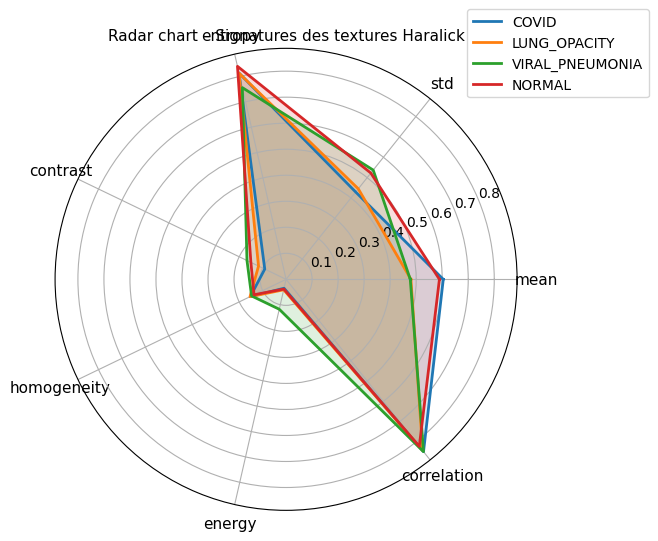

In [47]:
# Appel de la fonction
reps = ["covid", "lung_opacity", "viral_pneumonia", "normal"]
radar_all_haralick(haralick_features_norm, reps)

**INTERPRETATION DU GRAPHIQUE EN RADAR**

### ANALYSE

# REFRENCES



1.   Haralick, RM.; Shanmugam, K., “Textural features for image classification” IEEE Transactions on systems, man, and cybernetics 6 (1973): 610-621. [DOI:10.1109/TSMC.1973.4309314](https://doi.org/10.1109/TSMC.1973.4309314)
2.   

